In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import csv
import pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.calibration import calibration_curve

Load in the data we want (with only the first 13 columns of the predictions metadata because I wrote them to the file twice (oops))

In [2]:
predictions = xr.open_dataset("../ml_model_data/classification_model/predictions.nc")

Pull out the variable fields we want

In [3]:
true_no_hail = predictions.true_no_hail.values
true_hail = predictions.true_hail.values
true_sev_hail = predictions.true_sev_hail.values
true_sig_sev_hail = predictions.true_sig_sev_hail.values
#mesh = predictions.drop(('predicted_no_hail', 'predicted_hail', 'predicted_sev_hail', 'predicted_sig_sev_hail'))

predicted_no_hail = predictions.predicted_no_hail.values
predicted_hail = predictions.predicted_hail.values
predicted_sev_hail = predictions.predicted_sev_hail.values
predicted_sig_sev_hail = predictions.predicted_sig_sev_hail.values
#output = predictions.drop(('true_no_hail', 'true_hail', 'true_sev_hail', 'true_sig_sev_hail'))

In [4]:
# predict probabilities
nh_probs = predicted_no_hail[:,:,:].ravel()
h_probs = predicted_hail[:,:,:].ravel()
sh_probs = predicted_sev_hail[:,:,:].ravel()
ssh_probs = predicted_sig_sev_hail[:,:,:].ravel()
ssh_probs.shape

(15601664,)

## Skill Diagrams

Make each array of truth values into a 1D array instead of 3D

In [ ]:
nh_true = true_no_hail.ravel()
h_true = true_hail.ravel()
sh_true = true_sev_hail.ravel()
ssh_true = true_sig_sev_hail.ravel()
ssh_true.shape

Make a no-skill array of the same size as the other lists as a baseline comparison for the roc curve

In [ ]:
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(h_true))]

Format the data for the auc/roc curve plotting functions. It wants all prediction data in one array and all the truth data in one array and the no-skill data in one array. Add an extra dimension which holds the different categories of hail

In [13]:
truth = np.stack((nh_true,h_true,sh_true,ssh_true))
predict = np.stack((nh_probs,h_probs,sh_probs,ssh_probs))
noskill = np.stack((np.array(ns_probs),np.array(ns_probs),np.array(ns_probs),np.array(ns_probs)))

Calculate the AUC of the ROC curves for each category

In [14]:
ns_auc = roc_auc_score(h_true, ns_probs)
nh_auc = roc_auc_score(nh_true, nh_probs)
h_auc = roc_auc_score(h_true, h_probs)
sh_auc = roc_auc_score(sh_true, sh_probs)
ssh_auc = roc_auc_score(ssh_true, ssh_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Unet No Hail: ROC AUC=%.3f' % (nh_auc))
print('Unet Hail: ROC AUC=%.3f' % (h_auc))
print('Unet Sev Hail: ROC AUC=%.3f' % (sh_auc))
print('Unet Sig Sev Hail: ROC AUC=%.3f' % (ssh_auc))

No Skill: ROC AUC=0.500
Unet No Hail: ROC AUC=0.943
Unet Hail: ROC AUC=0.943
Unet Sev Hail: ROC AUC=0.969
Unet Sig Sev Hail: ROC AUC=0.990


Calculate the arrays for the roc curves. These functions calculate the false positive rate and the true positive rate for each category at each "threshold" value as determined by the function:

In [11]:
# calculate roc curves
ns_fpr, ns_tpr, ns_thresholds = roc_curve(h_true, ns_probs)
nh_fpr, nh_tpr, nh_thresholds = roc_curve(nh_true, nh_probs)
h_fpr, h_tpr, h_thresholds = roc_curve(h_true, h_probs)
sh_fpr, sh_tpr, sh_thresholds = roc_curve(sh_true, sh_probs)
ssh_fpr, ssh_tpr, ssh_thresholds = roc_curve(ssh_true, ssh_probs)

No Skill: Threshold=2.000
Unet No Hail: Threshold=217330.000
Unet Hail: Threshold=3891107.000
Unet Sev Hail: Threshold=2115166.000
Unet Sig Sev Hail: Threshold=2896754.000


Plot the ROC Curve. We omit the no hail case because there are only 3 degrees of freedom in this prediction (the probabilities for all the categories add up to 1 at each pixel). So no extra data is in the no hail case, so we remove it for simplicity in the plot

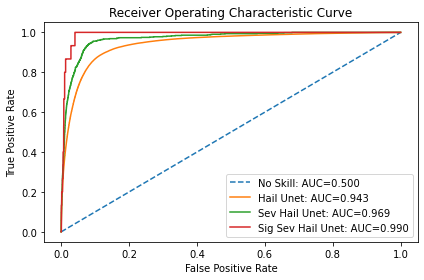

In [16]:
#ssh_thresholdshe roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill: AUC=%.3f' % (ns_auc))
plt.plot(h_fpr, h_tpr, linestyle='-', label='Hail Unet: AUC=%.3f' % (h_auc))
plt.plot(sh_fpr, sh_tpr, linestyle='-', label='Sev Hail Unet: AUC=%.3f' % (sh_auc))
plt.plot(ssh_fpr, ssh_tpr, linestyle='-', label='Sig Sev Hail Unet: AUC=%.3f' % (ssh_auc))
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
# show the legend
plt.legend()
plt.tight_layout()
plt.savefig('ROC_Curve_final.png')
# show the plot
plt.show()

## Calibration curve

Bin the predicted probabilites together in n_bins number of bins (in this case 100). Then calculate the observed frequency of all of the pixels in that bin. These are the variables plotted in the calibration curve

In [19]:
prob_true_nh, prob_pred_nh = calibration_curve(nh_true, nh_probs, n_bins=100)
prob_true_h, prob_pred_h = calibration_curve(h_true, h_probs, n_bins=100)
prob_true_sh, prob_pred_sh = calibration_curve(sh_true, sh_probs, n_bins=100)
prob_true_ssh, prob_pred_ssh = calibration_curve(ssh_true, ssh_probs, n_bins=100)

Plot the calibration curve/reliability diagram

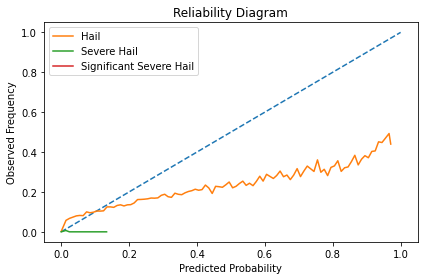

In [22]:
plt.plot([0,1], linestyle='--')
#plt.plot(prob_pred_nh, prob_true_nh, linestyle='-', label='No Hail')
plt.plot(prob_pred_h,prob_true_h, linestyle='-', label='Hail')
plt.plot(prob_pred_sh,prob_true_sh, linestyle='-', label='Severe Hail')
plt.plot(prob_pred_ssh,prob_true_ssh, linestyle='-', label='Significant Severe Hail')
plt.ylabel("Observed Frequency")
plt.xlabel("Predicted Probability")
plt.title("Reliability Diagram")
plt.legend(loc="best")
plt.tight_layout()
plt.savefig('Reliability_Diagram_final.png')